## Black-box Vector Optimization on Fairness
This notebook contains a vector optimization example on an ML fairness dataset, and compares Naive Elimination and PaVeBa algorithms.

In [8]:
import warnings
warnings.filterwarnings("ignore")

import vopy.algorithms
from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.datasets import get_dataset_instance
from vopy.utils.evaluate import calculate_epsilonF1_score

Let's first create an `Order` object to define our preference and visualize it's cone. Our preference correspond to allowing a little trade-off between objectives.

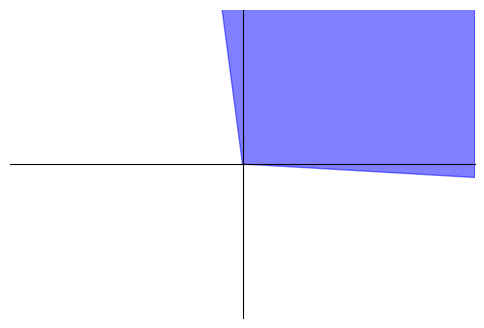

In [9]:
order = ConeTheta2DOrder(cone_degree=100)
fig_cone = order.ordering_cone.plot()

Now, we will create an instance of ML fairness dataset and visualize its Pareto front w.r.t. the order we created. This dataset contains different (200 candidates) hyperparameter selections of ROAD approach on a neural network architecture. The objectives are negative global unfairness measured by disparate impact measure and accuracy of the model. The $x$-axis corresponds to the negative global unfairness and $y$-axis corresponds to the accuracy of the model.

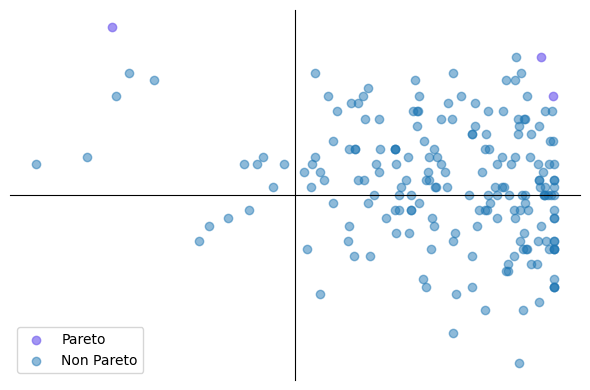

In [10]:
dataset_name = "Fairness"
dataset = get_dataset_instance(dataset_name)
fig_pareto = order.plot_pareto_set(dataset.out_data)

As you can see, there are a lot of hyperparameter combinations that give $0$ unfairness (right end of the plot), but due to our encoded preference, only the one with the highest accuracy is among the Pareto front. There are $3$ candidates that are Pareto.

#### Algorithms
We'll now run both algorithms (Naive Elimination and PaVeBa) and print out their results.

In [11]:
epsilon = 0.01
delta = 0.05
noise_var = epsilon

alg_names = ["NaiveElimination", "PaVeBa"]
alg_params = {
    "NaiveElimination": {"L": 5},
    "PaVeBa": {"conf_contraction": 8}
}

for alg_name in alg_names:
    set_seed(0)

    algorithm = getattr(vopy.algorithms, alg_name)(
        epsilon=epsilon, delta=delta,
        dataset_name=dataset_name, order=order, noise_var=noise_var, **alg_params[alg_name]
    )

    while True:
        is_done = algorithm.run_one_step()

        if is_done:
            break

    pred_pareto_indices = sorted(list(algorithm.P))
    pareto_indices = order.get_pareto_set(dataset.out_data)

    eps_f1 = calculate_epsilonF1_score(
        dataset, order, pareto_indices, pred_pareto_indices, epsilon
    )
    print(f"{alg_name} - epsilon-F1 Score: {eps_f1:.2f}")
    print(f"{alg_name} - Number of observations: {algorithm.sample_count}")

NaiveElimination - epsilon-F1 Score: 1.00
NaiveElimination - Number of observations: 1000
PaVeBa - epsilon-F1 Score: 1.00
PaVeBa - Number of observations: 235


The results show both Naive Elimination and PaVeBa achieve perfect results but with different number of samples. This is expected due to the nature of the algorithms. For details of the algorithms, see documentation for [vopy.algorithms](../algorithms.rst).